<a href="https://colab.research.google.com/github/jbrent00/Senior-Design-Project/blob/ResNet18-L2Reg(.0001)-LR(.01)-v1/Senior_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()


In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d chest_xray

import os

dataset_root = "chest_xray"
print("Dataset contents:", os.listdir(dataset_root))


In [ ]:
!mv /content/chest_xray/chest_xray/* /content/chest_xray/
!rm -r /content/chest_xray/chest_xray
print("Contents of /content/chest_xray:", os.listdir("/content/chest_xray"))



In [ ]:
dataset_root = "/content/chest_xray/"

# Paths to Train, Validation, Test Images
train_dir = os.path.join(dataset_root, "train")
val_dir = os.path.join(dataset_root, "val")
test_dir = os.path.join(dataset_root, "test")

# Verify paths
print("Train:", os.listdir(train_dir))
print("Validation:", os.listdir(val_dir))
print("Test:", os.listdir(test_dir))

In [ ]:
!ls -a /content/chest_xray/train
!ls -a /content/chest_xray/test

In [ ]:
!rm -r /content/chest_xray/train/.ipynb_checkpoints
!rm -r /content/chest_xray/test/.ipynb_checkpoints

In [ ]:
!ls -a /content/chest_xray/train
!ls -a /content/chest_xray/test

In [10]:
from PIL import Image

# Open the image using PIL
img = Image.open("/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg")

# Check the image mode
if img.mode == "L":
    print("Image is grayscale")
elif img.mode == "RGB":
    print("Image is RGB")
else:
    print("Image is in another format:", img.mode)

Image is grayscale


In [11]:
# Image Preprocessing (Resizing to 224x224, normalize pixel values, data augmentation)
import torchvision.transforms as transforms

# Define transformations for preprocessing
preprocess_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for RGB
])

# Define transformations for augmentation
augment_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Augmentation
])



In [12]:
# Create PyTorch Dataset and Dataloaders
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Create dataset objects
train_dataset = ImageFolder(root="/content/chest_xray/train", transform=preprocess_transforms)
val_dataset = ImageFolder(root="/content/chest_xray/val", transform=preprocess_transforms)
test_dataset = ImageFolder(root="/content/chest_xray/test", transform=preprocess_transforms)

# Create DataLoaders (only for test since we are handling training/validation in K-Fold Loop)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 5216
Validation samples: 16
Test samples: 624


In [ ]:
# Display some sample images to confirm dataset is correctly loaded
import matplotlib.pyplot as plt
import numpy as np

# Function to show images
def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * 0.5 + 0.5  # Unnormalize
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title("Normal" if label == 0 else "Pneumonia")
        axes[i].axis("off")
    plt.show()

# Display images from the training set
show_images(train_dataset)


In [13]:
print("Class-to-Index Mapping:", train_dataset.class_to_idx)


Class-to-Index Mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


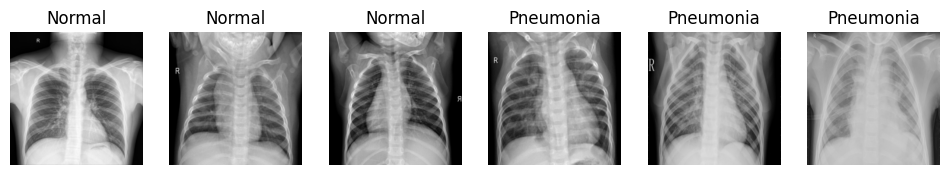

In [ ]:
import random

def show_balanced_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    # Collect equal samples of both classes
    normal_images = [img for img, label in dataset if label == 0]
    pneumonia_images = [img for img, label in dataset if label == 1]

    # Ensure we have at least num_images/2 images per class
    num_per_class = num_images // 2
    normal_samples = random.sample(normal_images, min(num_per_class, len(normal_images)))
    pneumonia_samples = random.sample(pneumonia_images, min(num_per_class, len(pneumonia_images)))

    # Combine and shuffle
    samples = normal_samples + pneumonia_samples
    random.shuffle(samples)

    # Display images
    for i, img in enumerate(samples):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * 0.5 + 0.5  # Unnormalize
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title("Normal" if i < num_per_class else "Pneumonia")
        axes[i].axis("off")

    plt.show()

# Display balanced images
show_balanced_images(train_dataset)


In [19]:
# Initialize the Model: ResNet-18

import torch
import torch.nn as nn
import torchvision.models as models

# Load the ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for binary classification
num_features = model.fc.in_features  # Get the input size of the FC layer
model.fc = nn.Linear(num_features, 2)  # Change output to 2 classes (NORMAL, PNEUMONIA)

# Unfreeze the parameters in the new fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)  # Verify model architecture


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:

# Check if layers are frozen
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Grad: {param.requires_grad}")

Layer: conv1.weight, Requires Grad: False
Layer: bn1.weight, Requires Grad: False
Layer: bn1.bias, Requires Grad: False
Layer: layer1.0.conv1.weight, Requires Grad: False
Layer: layer1.0.bn1.weight, Requires Grad: False
Layer: layer1.0.bn1.bias, Requires Grad: False
Layer: layer1.0.conv2.weight, Requires Grad: False
Layer: layer1.0.bn2.weight, Requires Grad: False
Layer: layer1.0.bn2.bias, Requires Grad: False
Layer: layer1.1.conv1.weight, Requires Grad: False
Layer: layer1.1.bn1.weight, Requires Grad: False
Layer: layer1.1.bn1.bias, Requires Grad: False
Layer: layer1.1.conv2.weight, Requires Grad: False
Layer: layer1.1.bn2.weight, Requires Grad: False
Layer: layer1.1.bn2.bias, Requires Grad: False
Layer: layer2.0.conv1.weight, Requires Grad: False
Layer: layer2.0.bn1.weight, Requires Grad: False
Layer: layer2.0.bn1.bias, Requires Grad: False
Layer: layer2.0.conv2.weight, Requires Grad: False
Layer: layer2.0.bn2.weight, Requires Grad: False
Layer: layer2.0.bn2.bias, Requires Grad: Fals

In [21]:
# Define Loss Function and Optimizer (using Cross Entropy Loss and Adam Optimizer)

import torch.optim as optim

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=.0001)


In [22]:
# Function to Train the Model
# Iterate through the training set in batches, compute the predictions,
# compute the loss, update the models weights, and validate using validation set.

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []


    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get class predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * (correct / total)
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_correct, val_total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * (val_correct / val_total)
        val_avg_loss = val_loss / len(val_loader)
        val_losses.append(val_avg_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_avg_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, train_accs, val_losses, val_accs # Return performance metrics



In [23]:
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10] - Loss: 0.2315, Acc: 91.10% | Val Loss: 0.2015, Val Acc: 93.75%
Epoch [2/10] - Loss: 0.1997, Acc: 92.93% | Val Loss: 0.9240, Val Acc: 50.00%
Epoch [3/10] - Loss: 0.1291, Acc: 95.21% | Val Loss: 0.5457, Val Acc: 62.50%
Epoch [4/10] - Loss: 0.1799, Acc: 93.71% | Val Loss: 0.3985, Val Acc: 75.00%
Epoch [5/10] - Loss: 0.1707, Acc: 94.29% | Val Loss: 0.4616, Val Acc: 81.25%
Epoch [6/10] - Loss: 0.1198, Acc: 95.80% | Val Loss: 0.8072, Val Acc: 62.50%
Epoch [7/10] - Loss: 0.1246, Acc: 95.59% | Val Loss: 0.3559, Val Acc: 81.25%
Epoch [8/10] - Loss: 0.1325, Acc: 95.34% | Val Loss: 0.3169, Val Acc: 87.50%
Epoch [9/10] - Loss: 0.1230, Acc: 95.78% | Val Loss: 0.2556, Val Acc: 87.50%
Epoch [10/10] - Loss: 0.1426, Acc: 95.26% | Val Loss: 0.3182, Val Acc: 87.50%


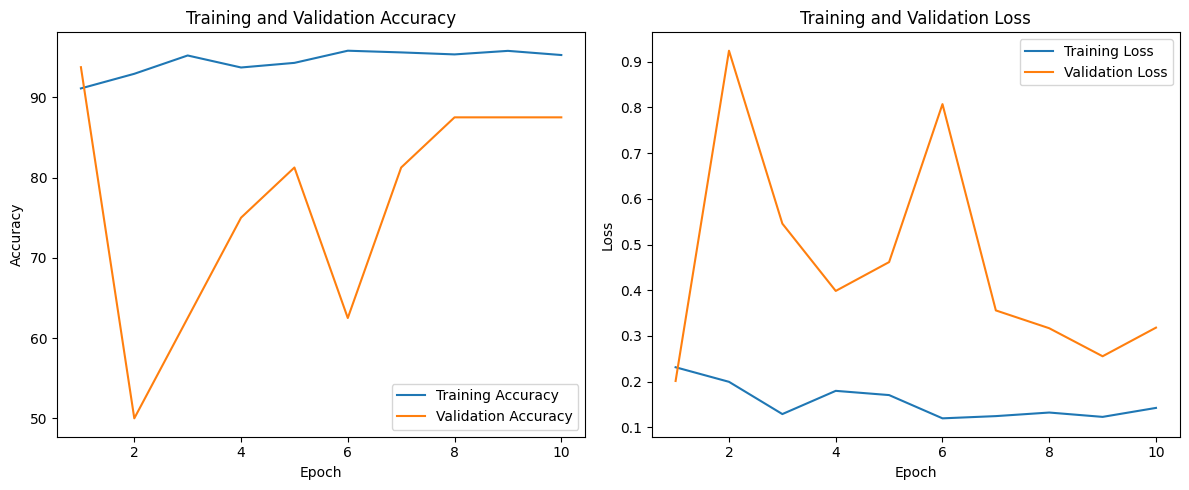

In [24]:
import matplotlib.pyplot as plt

def plot_performance(train_losses, train_accs, val_losses, val_accs):
    """Plots training and validation accuracy/loss vs. epoch."""

    epochs = range(1, len(train_losses) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Call the plotting function
plot_performance(train_losses, train_accs, val_losses, val_accs)

In [ ]:
# K-Fold Cross Validation
import torch
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

# Combine train and validation datasets
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# Define the number of folds (e.g., K=5)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store metrics for each fold
all_train_losses = []
all_train_accs = []
all_val_losses = []
all_val_accs = []


# K-fold cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(combined_dataset)):
    print(f"Fold {fold + 1}:")

    # Create train and validation subsets using the indices
    train_subset = Subset(combined_dataset, train_index)
    val_subset = Subset(combined_dataset, val_index)

    # Create DataLoaders for this fold
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Create a new model instance
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # create fresh model instance
    num_features = model.fc.in_features  # Get the input size of the FC layer
    model.fc = nn.Linear(num_features, 2)  # Change output to 2 classes (NORMAL, PNEUMONIA)
    model = model.to(device)

    # Create a new optimizer instance
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

    # Train and evaluate for this fold (using the SAME model)
    train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

    # Store the metrics
    all_train_losses.append(train_losses)
    all_train_accs.append(train_accs)
    all_val_losses.append(val_losses)
    all_val_accs.append(val_accs)



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average loss and accuracy across folds for each epoch
avg_train_losses = np.mean(all_train_losses, axis=0)
avg_train_accs = np.mean(all_train_accs, axis=0)
avg_val_losses = np.mean(all_val_losses, axis=0)
avg_val_accs = np.mean(all_val_accs, axis=0)

# Calculate average loss per fold (across all epochs within each fold)
avg_loss_per_fold = [np.mean(fold_losses) for fold_losses in all_val_losses]

# Plot average loss per fold
plt.figure()
folds = range(1, k + 1)  # Create a range of fold values with step size 1
plt.plot(folds, avg_loss_per_fold, marker='o', linestyle='-')
plt.title("Average Loss per Fold")
plt.xlabel("Fold")
plt.ylabel("Average Loss")
plt.xticks(folds)  # Explicitly set x-axis ticks to fold values
plt.show()

# 2. Average Validation Accuracy per Fold
avg_val_accs_per_fold = [np.mean(accs) for accs in all_val_accs]
plt.figure()
sns.barplot(x=list(range(1, k + 1)), y=avg_val_accs_per_fold)
plt.title("Average Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

# 3. Overall Average Validation Accuracy
overall_avg_val_acc = np.mean(avg_val_accs_per_fold)
print(f"Overall Average Validation Accuracy: {overall_avg_val_acc:.2f}%")

In [25]:
# Function to evaluate the model. Make predictions, calculate accuracy

def evaluate_model(model, test_loader):
    model.eval()  # Set to evaluation mode
    correct, total = 0, 0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculations
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get class predictions

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    return all_labels, all_preds  # Return results for further analysis


In [26]:
labels, preds = evaluate_model(model, test_loader)

from sklearn.metrics import classification_report

# Print detailed classification metrics
print(classification_report(labels, preds, target_names=['NORMAL', 'PNEUMONIA']))


Test Accuracy: 84.13%
              precision    recall  f1-score   support

      NORMAL       0.95      0.61      0.74       234
   PNEUMONIA       0.81      0.98      0.89       390

    accuracy                           0.84       624
   macro avg       0.88      0.80      0.81       624
weighted avg       0.86      0.84      0.83       624



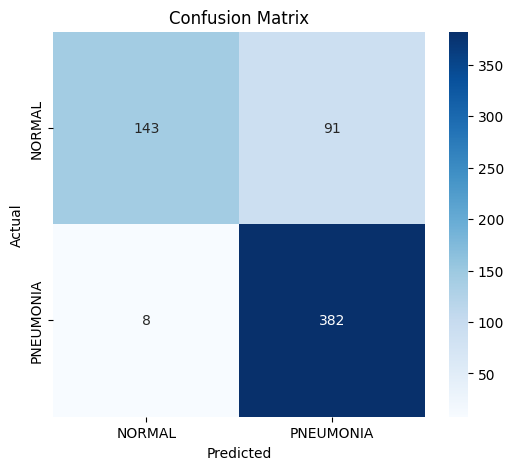

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [28]:
# Save the state dictionary of the model for later use

model_path = "/content/drive/My Drive/chest_xray_models/resnet18_L2Reg_01LR_v1.pth"

# Create the parent directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")


Model saved to /content/drive/My Drive/chest_xray_models/resnet18_L2Reg_01LR_v1.pth
